In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from dmba import classificationSummary, liftChart, gainsChart

In [12]:
movies = pd.read_csv('../data/iac_dataset/modeling_data.csv')

features = ['keywords', 'cast', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

# Preprocessing prior to modeling

In [13]:
movies['director'] = movies['director'].astype(str).str.replace('.', '')
movies['director'] = movies['director'].astype(str).str.replace(' ', '_')

movies['prod_company'] = movies['prod_company'].astype(str).str.replace('.', '')
movies['prod_company'] = movies['prod_company'].astype(str).str.replace(' ', '_')

/var/folders/ll/snp8v88x0dz1nl1l9yq19m680000gn/T/ipykernel_75312/453367950.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['director'] = movies['director'].astype(str).str.replace('.', '')
/var/folders/ll/snp8v88x0dz1nl1l9yq19m680000gn/T/ipykernel_75312/453367950.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['prod_company'] = movies['prod_company'].astype(str).str.replace('.', '')


In [14]:
movies['label'] = pd.cut(movies.avg_rating, bins=[0,3.4,5],labels=[0,1])

In [15]:
X = movies[['genres','cast','director','prod_company','popularity','revenue_millions']]
y = movies[['avg_rating','label','title']]

In [16]:
# creating dummies
genres_cat = X.genres.str.join('|').str.get_dummies().add_prefix('genres_')
X = pd.concat([X, genres_cat], axis=1)
X = X.drop(columns='genres')

In [17]:
# creating dummies
cast_cat = X.cast.str.join('|').str.get_dummies().add_prefix('cast_')
X = pd.concat([X, cast_cat], axis=1)
X = X.drop(columns='cast')

In [18]:
keyword_cat = X.director.str.get_dummies().add_prefix('director_')
X = pd.concat([X, keyword_cat], axis=1)
X = X.drop(columns='director')

In [19]:
keyword_cat = X.prod_company.str.get_dummies().add_prefix('prod_company_')
X = pd.concat([X, keyword_cat], axis=1)
X = X.drop(columns='prod_company')

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.20, random_state = 2020)

In [21]:
movie_knn = KNeighborsClassifier(n_neighbors=24, metric='cosine')
movie_knn.fit(X_train, y_train['label'])

y_pred = movie_knn.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.6967)

       Prediction
Actual    0    1
     0 1855  367
     1  565  286
precision: 0.43797856049004597
recall: 0.33607520564042304


In [22]:
# Training Logistic Model
movie_log = LogisticRegression( random_state=2020, max_iter=10000)
movie_log.fit(X_train, y_train['label'])

# Predicting using training set
y_pred = movie_log.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.7410)

       Prediction
Actual    0    1
     0 1997  225
     1  571  280
precision: 0.5544554455445545
recall: 0.3290246768507638


In [23]:
movie_tree = DecisionTreeClassifier(random_state=2020)
movie_tree.fit(X_train, y_train['label'])
y_pred = movie_tree.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.7114)

       Prediction
Actual    0    1
     0 1891  331
     1  556  295
precision: 0.4712460063897764
recall: 0.34665099882491185


In [24]:
movie_rf = RandomForestClassifier(random_state=2020)
movie_rf.fit(X_train, y_train['label'])
y_pred = movie_rf.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.7491)

       Prediction
Actual    0    1
     0 2140   82
     1  689  162
precision: 0.6639344262295082
recall: 0.19036427732079905


# Cummulative Gains Chart

In [57]:
def modelGainsChart(model, title, color, label, ax=None):
    result = pd.DataFrame({
        'actual': np.array(y_val['label']),
        'prob': model.predict_proba(X_val)[:, 1]
    })
    y_prob = result.prob
    result = result.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    ax = gainsChart(result.actual, ax=ax, color=color, label= f'{label}, auc={round(roc_auc_score(y_val.label,y_prob),3)}')
    ax.set_title(title)
    return ax


Text(0.5, 1.0, 'All models')

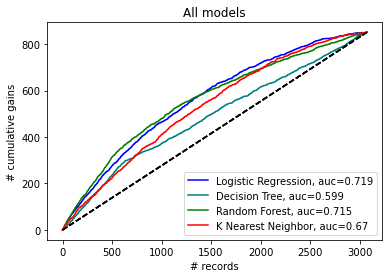

In [58]:
ax = modelGainsChart(movie_log, 'Logistic regression','blue','Logistic Regression')
modelGainsChart(movie_tree, 'Decision tree','teal','Decision Tree', ax)
modelGainsChart(movie_rf, 'Random forest','green','Random Forest', ax)
modelGainsChart(movie_knn, 'K Nearest Neighbor','red','K Nearest Neighbor', ax)
ax.legend()
ax.set_title('All models')

# Lift Chart using best model: Random Forest

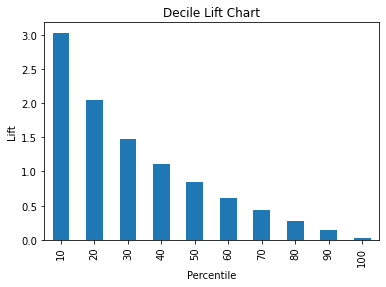

In [60]:
rf_prob = movie_rf.predict_proba(X_val)[:, 1]
rf_prob = -np.sort(-rf_prob)

ax = liftChart(pd.Series(rf_prob), labelBars=False)
ax.set_ylabel('Lift')
ax.set_title('Decile Lift Chart')
plt.show()

In [30]:
print(f'Top 10 percent would yield about {round(len(rf_prob)*.10,)} movies that can be added to the collection which would be 3 times as likely to be highly rated')
print(f'Top 20 percent would yield about {round(len(rf_prob)*.20,)} movies that can be added to the collection which would be 2 times as likely to be highly rated')

Top 10 percent would yield about 307 movies that can be added to the collection which would be 3 times as likely to be highly rated
Top 20 percent would yield about 615 movies that can be added to the collection which would be 2 times as likely to be highly rated
